In [2]:
# !pip uninstall pandas -y
# !pip install pandas


### 1. Imports 및 클래스 정의

In [3]:
# import pandas as pd
import matplotlib.pyplot as plt
import os
import concurrent.futures
from tqdm import tqdm
# from sqlalchemy import create_engine
import pymysql
import datetime
import random
import configparser
from cryptography.fernet import Fernet
import mysql.connector
from datetime import timedelta
import numpy as np
import pandas as pd



class Position:
    def __init__(self, buy_price, quantity,order,additional_buy_drop_rate,sell_profit_rate):
        self.buy_price = buy_price
        self.quantity = quantity
        self.order = order  # 포지션의 차수
        self.additional_buy_drop_rate = additional_buy_drop_rate  
        self.sell_profit_rate = sell_profit_rate 



### 2. 롤링 윈도우 계산 함수

In [4]:

# 데이터베이스에서 조건을 만족하는 종목을 동적으로 가져오는 함수
def get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, buy_threshold, db_params, consider_delisting):
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    date_str = pd.to_datetime(date).strftime('%Y-%m-%d')

    if consider_delisting:
        query = f"""
        SELECT ticker 
        FROM stock_data 
        WHERE date = '{date_str}' 
        AND PER > 0 
        AND PER <= {per_threshold} 
        AND PBR > 0 
        AND PBR <= {pbr_threshold} 
        AND dividend >= {div_threshold}
        AND normalized_value <= {buy_threshold}
        """
    else:
        query = f"""
        SELECT sd.ticker 
        FROM stock_data sd
        LEFT JOIN (
            SELECT ticker, MAX(date) as last_date
            FROM stock_data
            GROUP BY ticker
        ) ld ON sd.ticker = ld.ticker
        WHERE sd.date = '{date_str}' 
        AND sd.PER > 0 
        AND sd.PER <= {per_threshold} 
        AND sd.PBR > 0 
        AND sd.PBR <= {pbr_threshold} 
        AND sd.dividend >= {div_threshold}
        AND sd.normalized_value <= {buy_threshold}
        AND ld.last_date >= '2024-06-01'
        """
    
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['ticker'])
    cursor.close()
    conn.close()
    return df['ticker'].tolist()

# MySQL에서 데이터를 불러오는 함수
def load_stock_data_from_mysql(ticker, start_date, end_date, db_params):
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    
    # start_date 이전 5년의 데이터를 함께 가져오기 위해 5년 전 날짜 계산
    extended_start_date = pd.to_datetime(start_date) - timedelta(days=252*5)
    extended_start_date_str = extended_start_date.strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    query = f"""
        SELECT * FROM stock_data 
        WHERE ticker = '{ticker}' AND date BETWEEN '{extended_start_date_str}' AND '{end_date_str}'
    """
    cursor.execute(query)
    
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    
    # 날짜 형식 변환 및 인덱스 설정
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    cursor.close()
    conn.close()

    # 5년 동안의 최저값 계산
    df['five_year_low'] = df['close'].rolling(window=252*5, min_periods=1).min()
    
    # start_date 이후의 데이터만 반환
    return df[df.index >= pd.to_datetime(start_date)]


def get_data_for_period(stock_data, start_year=2009, end_year=2023):
    period_data = {}
    for code, data in stock_data.items():
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)
        period_data[code] = data[(data.index >= start_date) & (data.index <= end_date)]
    return period_data
    

### 3. 매수 및 매도 수익률 계산 함수

In [5]:
def calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits):
    return 1 - np.power((five_year_low / last_buy_price), (1 / (num_splits - 1)))

def calculate_sell_profit_rate(buy_profit_rate):
    """
    매수 수익률을 기반으로 매도 수익률을 계산
    :buy_profit_rate: 매수 기준 수익률
    :return: 계산된 매도 수익률
    """
    sell_profit_rate = (1 / (1 - buy_profit_rate)) - 1
    return sell_profit_rate 
    

### 4. 매수 및 매도 조건 체크 함수

In [6]:

def initial_buy_sell(row, positions, capital, investment_per_split, buy_threshold, buy_signals, sell_signals, code):
    normalized = row['normalized_value']
    five_year_low = row['five_year_low']
    current_order = len(positions) + 1
    # 수수료 및 증권거래세 비율
    buy_commission_rate = 0.00015
    sell_commission_rate = 0.00015
    sell_tax_rate = 0.0018
    # 변수 초기화
    additional_buy_drop_rate = 0
    sell_profit_rate = 0

    # 1차 진입 조건 : normalized 가격이 buy_threshold보다 낮고 아직 매수하지 않았을 때
    if normalized < buy_threshold and len(positions) == 0 and capital >= investment_per_split:
        #차수별 수익률 계산 
        additional_buy_drop_rate = calculate_additional_buy_drop_rate(row['close'], five_year_low, num_splits)
        # 매도 수익률 계산
        sell_profit_rate = calculate_sell_profit_rate(additional_buy_drop_rate)
        quantity = int(investment_per_split / row['close'])
        total_cost = int(row['close'] * quantity * (1 + buy_commission_rate))
        new_position = Position(row['close'], quantity, 1, sell_profit_rate, additional_buy_drop_rate)
        positions.append(new_position)
        capital -= total_cost
        # row.name은 현재 행의 인덱스 (날짜)를 반환. # 매수 시점 기록
        buy_signals.append((row.name, row['close']))
    # 청산된 종목 확인을 위한 변수
    liquidated = False

    # 1차 청산 조건
    for position in positions:
        if row['close'] > position.buy_price * (1 + position.sell_profit_rate) and position.order == 1:
            total_revenue = int(row['close'] * position.quantity * (1 - sell_commission_rate - sell_tax_rate))
            capital += total_revenue
            positions.remove(position)
            sell_signals.append((row.name, row['close']))
            liquidated = True
    # 청산된 경우 종목 코드 반환
    if liquidated and not positions:
        return positions, capital, code
    else:
        return positions, capital, None

# 기존종목의 2차 이상의 추가 매수 함수
def additional_buy(row, positions, capital, investment_per_split, num_splits, buy_signals):
    # 수수료 비율
    buy_commission_rate = 0.00015
    # 추가 매수 조건: 이미 매수했고, 현재 가격이 이전 매수 가격보다 더 낮아졌을 때
    if positions and len(positions) < num_splits and capital >= investment_per_split:
        # 마지막 포지션(가장 최근 매수)
        last_position = positions[-1]
        if row['close'] <= last_position.buy_price * (1 - last_position.additional_buy_drop_rate):
            quantity = int(investment_per_split / row['close'])
            total_cost = int(row['close'] * quantity * (1 + buy_commission_rate))
            new_position = Position(row['close'], quantity, len(positions) + 1, last_position.sell_profit_rate, last_position.additional_buy_drop_rate)
            positions.append(new_position)
            capital -= total_cost
            buy_signals.append((row.name, row['close']))

    return positions, capital

#2차 이상의 매도 함수
def additional_sell(row, positions, capital, sell_signals):
    # 수수료 및 증권거래세 비율
    sell_commission_rate = 0.00015
    sell_tax_rate = 0.0018

    for position in positions:
        # 2차이면서 매수가보다 일정비율이상의 조건에서
        if row['close'] >= position.buy_price * (1 + position.sell_profit_rate) and position.order > 1:
            total_revenue = int(row['close'] * position.quantity * (1 - sell_commission_rate - sell_tax_rate))
            capital += total_revenue
            positions.remove(position)
            # 매도신호(날짜,단가) 저장
            sell_signals.append((row.name, row['close']))

    return positions, capital



### 7. 종목 데이터 로드 및 기간 설정 함수

In [7]:
def get_trading_dates_from_db(db_params, start_date, end_date):
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    query = f"SELECT DISTINCT date FROM stock_data WHERE date BETWEEN '{start_date}' AND '{end_date}' ORDER BY date"
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['date'])
    
    cursor.close()
    conn.close()
    trading_dates = df['date'].tolist()
    return trading_dates


### 8. 포트폴리오 백테스팅 함수

In [8]:
def portfolio_backtesting(initial_capital, num_splits, investment_ratio, buy_threshold, start_date, 
                          end_date, db_params, per_threshold, pbr_threshold, div_threshold, 
                          min_additional_buy_drop_rate, consider_delisting,max_stocks=20):
    total_portfolio_value = initial_capital
    capital = initial_capital  # capital을 초기 자본으로 초기화
    positions_dict = {}  # 각 종목별 포지션 리스트를 위한 딕셔너리
    buy_signals = []  # 매수 신호를 기록하는 리스트
    sell_signals = []  # 매도 신호를 기록하는 리스트
    portfolio_values_over_time = []
    capital_over_time = []  # 자본 변화 추적을 위한 리스트 초기화

    # NumPy 배열로 변환
    portfolio_values_over_time = np.array(portfolio_values_over_time)
    capital_over_time = np.array(capital_over_time)

    # 추가: 진입된 종목과 그들의 현재 최대 차수를 추적하기 위한 딕셔너리
    entered_stocks = set()  # 진입된 종목을 추적하는 집합
    current_orders_dict = {}  # 종목별 현재 차수를 추적하는 딕셔너리
    loaded_stock_data = {}   

    previous_month = None
    
    # 특정 기간 내의 모든 거래 날짜 가져오기
    all_trading_dates = get_trading_dates_from_db(db_params, start_date, end_date)

    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    query = """
        CREATE TEMPORARY TABLE delisted_stocks AS
        SELECT ticker, MAX(date) AS delisted_date
        FROM stock_data
        GROUP BY ticker
        HAVING MAX(date) < '2024-06-01'
    """
    cursor.execute(query)
    cursor.close()
    conn.close()

    # 백테스팅 실행
    for date_str  in all_trading_dates:
        print(date_str, '진입종목수',len(entered_stocks))  
        date = pd.to_datetime(date_str)# 날짜 문자열을 datetime 객체로 변환
        # 상장폐지된 종목 처리
        if consider_delisting:
            conn = mysql.connector.connect(**db_params)
            cursor = conn.cursor()
            query = """
                SELECT delisted_stocks.ticker
                FROM delisted_stocks
                WHERE delisted_stocks.delisted_date = %s
            """
            cursor.execute(query, (date_str,))
            delisted_stocks = cursor.fetchall()
            cursor.close()
            conn.close()
            for delisted_stock in delisted_stocks:
                ticker = delisted_stock[0]
                if ticker in positions_dict:
                    last_close_price = loaded_stock_data[ticker].loc[loaded_stock_data[ticker].index[-1], 'close']
                    for position in positions_dict[ticker]:
                        capital += position.quantity * last_close_price
                    del positions_dict[ticker]
                    entered_stocks.discard(ticker)
                    print('상폐로 entered_stocks 삭제 완료')
                    if ticker in current_orders_dict:
                        del current_orders_dict[ticker]
                        print('상폐로 current_orders_dict 삭제 완료')

        
        current_month = date.month
        # 새로운 달의 시작일 경우, investment_per_split 업데이트
        if current_month != previous_month:
            investment_per_split = total_portfolio_value * investment_ratio // num_splits
            previous_month = current_month
            print(date_str, '진입종목수',len(entered_stocks))    
            
        
        # 기존 종목 2차 이상의 매도
        for code in list(entered_stocks):
            if date in loaded_stock_data[code].index:
                row = loaded_stock_data[code].loc[date] 

                positions = positions_dict.get(code, []) # 현재 종목의 포지션 리스트
                
                positions, capital = additional_sell(row, positions, capital, sell_signals)
                positions_dict[code] = positions  # 업데이트된 포지션 리스트를 다시 딕셔너리에 저장
                
                
                # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                if positions:
                    current_order = max(position.order for position in positions)
                    current_orders_dict[code] = current_order
                else:
                    if code in current_orders_dict:
                        del current_orders_dict[code]
                

                
        # 기존 종목 1차 청산
        for code in list(entered_stocks):
            if date in loaded_stock_data[code].index:
                row = loaded_stock_data[code].loc[date]
                positions = positions_dict.get(code, [])
                positions, capital, liquidated_code = initial_buy_sell(row, positions, capital, investment_per_split, buy_threshold, buy_signals, sell_signals, code)
                positions_dict[code] = positions

                # 청산된 종목 제거
                if liquidated_code:
                    entered_stocks.discard(liquidated_code)
                    if liquidated_code in current_orders_dict:
                        del current_orders_dict[liquidated_code]
                else:
                    # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                    if positions:
                        current_order = max(position.order for position in positions)
                        current_orders_dict[code] = current_order
                    else:
                        if code in current_orders_dict:
                            del current_orders_dict[code]        
                        
                        
        # 신규 종목 매수 및 기존 종목 추가 매수
        if len(entered_stocks) < max_stocks and capital > investment_per_split:
            stock_codes = get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, buy_threshold, db_params, consider_delisting)
            random.shuffle(stock_codes)
            print(len(stock_codes))
            for code in stock_codes:
                if  len(entered_stocks) < max_stocks  and code not in entered_stocks:
                    loaded_stock_data[code] = load_stock_data_from_mysql(code, start_date, end_date, db_params)
                    if date in loaded_stock_data[code].index: # 현재 날짜에 데이터가 있는지 확인
                        sample_row = loaded_stock_data[code].loc[date]  # 현재 날짜의 데이터를 사용
                        five_year_low = sample_row['five_year_low']
                        last_buy_price = sample_row['close']
                        additional_buy_drop_rate = calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits)
                        
                        if additional_buy_drop_rate >= min_additional_buy_drop_rate:    
                            # print("ok")
                            row = loaded_stock_data[code].loc[date]
                            positions = []
                            positions, capital, liquidated_code = initial_buy_sell(row, positions, capital, investment_per_split, buy_threshold, buy_signals, sell_signals, code)
                            positions_dict[code] = positions
                        
                            if positions:
                                entered_stocks.add(code)
                                current_order = max(position.order for position in positions)
                                current_orders_dict[code] = current_order  
                            else:
                                if code in loaded_stock_data:
                                    del loaded_stock_data[code]
                        
        # 기존 종목 추가 매수
        for code in list(entered_stocks):
            if date in loaded_stock_data[code].index:
                row = loaded_stock_data[code].loc[date]
                positions = positions_dict.get(code, [])
                positions, capital = additional_buy(row, positions, capital, investment_per_split, num_splits, buy_signals)
                positions_dict[code] = positions                
                        
                # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                if positions:  # 해당 종목에 포지션이 있으면
                    entered_stocks.add(code)
                    current_order = max(position.order for position in positions)
                    current_orders_dict[code] = current_order
                else : 
                    if capital < investment_per_split:
                        entered_stocks.discard(code)
        # 포트폴리오 가치 업데이트
        # current_stock_value=np.sum([position.quantity * loaded_stock_data[code].loc[date]['close'] for code, positions in positions_dict.items() for position in positions])
        current_stock_value = np.sum([
            position.quantity * loaded_stock_data[code].loc[date]['close']
            for code, positions in positions_dict.items()
            for position in positions
            if date in loaded_stock_data[code].index
        ])

        total_portfolio_value = np.sum([capital, current_stock_value])
        portfolio_values_over_time = np.append(portfolio_values_over_time, total_portfolio_value)
        capital_over_time = np.append(capital_over_time, capital)  # 현재 자본 추가
        # for code, order in current_orders_dict.items():
        #     print(f"종목 코드 {code}의 현재 최대 차수: {order}")
     # 백테스팅 루프 종료 후
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    final_portfolio_value = portfolio_values_over_time[-1]
    cagr = np.power(final_portfolio_value / initial_capital, 1 / total_years) - 1
    print('백테스팅 종료')    
    return positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr


In [9]:
# MDD 계산 함수 (numpy 적용)
def calculate_mdd(portfolio_values):
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    mdd = np.max(drawdown)
    return mdd
# 백테스팅 결과 시각화 함수
def plot_backtesting_results(all_trading_dates, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals):
    plt.figure(figsize=(14, 7))
    plt.plot(all_trading_dates, portfolio_values_over_time, label='Portfolio Value', color='blue')
    plt.plot(all_trading_dates, capital_over_time, label='Capital', color='green')
    if buy_signals:
        buy_dates, buy_prices = zip(*buy_signals)
        plt.scatter(buy_dates, buy_prices, marker='^', color='red', label='Buy Signal')
    if sell_signals:
        sell_dates, sell_prices = zip(*sell_signals)
        plt.scatter(sell_dates, sell_prices, marker='v', color='black', label='Sell Signal')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio Value and Capital Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# 백테스팅 결과 분석 함수
def analyze_backtesting_results(positions_dict, total_portfolio_value, cagr, mdd):
    print(f"최종 포트폴리오 가치: {total_portfolio_value}")
    print(f"CAGR: {cagr}")
    print(f"MDD: {mdd:.2%}")
    for ticker, positions in positions_dict.items():
        print(f"종목: {ticker}")
        for position in positions:
            print(f"  매수가: {position.buy_price}, 수량: {position.quantity}, 차수: {position.order}")


def backtesting_wrapper(params):
    num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks = params
    try:
        _, _, _, _, _, _, _, cagr, mdd = portfolio_backtesting(
            initial_capital, num_splits, investment_ratio, buy_threshold, start_date, end_date, db_params, per_threshold, pbr_threshold, div_threshold, min_additional_buy_drop_rate, consider_delisting, max_stocks
        )
        return num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks, cagr, mdd
    except Exception as e:
        print(f'Error in backtesting: {e}')
        return num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks, None, None  # 오류가 발생한 경우 CAGR과 MDD를 None으로 설정

 
def check_if_already_calculated(num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks, results_file):
    if os.path.exists(results_file):
        existing_results = pd.read_csv(results_file)
        return any((existing_results['num_splits'] == num_splits) & 
                   (existing_results['buy_threshold'] == buy_threshold) &
                   (existing_results['investment_ratio'] == investment_ratio) &
                   (existing_results['consider_delisting'] == consider_delisting) &
                   (existing_results['max_stocks'] == max_stocks))
    return False


def run_backtesting_for_period(num_splits, buy_threshold, investment_ratio, start_year, end_year, db_params, per_threshold, pbr_threshold, div_threshold, min_additional_buy_drop_rate, consider_delisting, max_stocks):
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    _, total_portfolio_value, _, _, _, _, _, cagr, mdd = portfolio_backtesting(
        100000000, num_splits, investment_ratio, buy_threshold, start_date, end_date, db_params, per_threshold, pbr_threshold, div_threshold, min_additional_buy_drop_rate, consider_delisting, max_stocks
    )
    return total_portfolio_value, cagr, mdd



def calculate_average_results(backtesting_results):
    total_values = np.array([result[0] for result in backtesting_results])
    cagr_values = np.array([result[1] for result in backtesting_results])
    mdd_values = np.array([result[2] for result in backtesting_results])

    average_total_value = np.mean(total_values)
    average_cagr = np.mean(cagr_values)
    average_mdd = np.mean(mdd_values)

    return average_total_value, average_cagr, average_mdd

# 시간 기간에 따른 평균 CAGR을 계산하는 래퍼 함수
def average_cagr_wrapper(params):
    num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks = params
    period_results = []
    for start_year, end_year in time_periods:
        try:
            total_value, cagr, mdd = run_backtesting_for_period(
                num_splits, buy_threshold, investment_ratio, start_year, end_year, db_params, per_threshold, pbr_threshold, div_threshold, min_additional_buy_drop_rate, consider_delisting, max_stocks
            )
            period_results.append((total_value, cagr, mdd))
        except Exception as e:
            print(f'Error in backtesting for period {start_year}-{end_year}: {e}')
            period_results.append((0, None, None))  # 오류가 발생한 경우 결과를 (0, None, None)으로 설정

    average_results = calculate_average_results(period_results)
    return num_splits, buy_threshold, investment_ratio, consider_delisting, max_stocks, average_results[0], average_results[1], average_results[2]



### 10. 메인 실행 코드

2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
118
2004-01-05 진입종목수 40
2004-01-06 진입종목수 40
2004-01-07 진입종목수 40
2004-01-08 진입종목수 40
2004-01-09 진입종목수 40
119
2004-01-12 진입종목수 40
2004-01-13 진입종목수 40
120
2004-01-14 진입종목수 40
120
2004-01-15 진입종목수 40
2004-01-16 진입종목수 40
2004-01-19 진입종목수 40
2004-01-20 진입종목수 40
2004-01-26 진입종목수 40
126
2004-01-27 진입종목수 40
2004-01-28 진입종목수 40
2004-01-29 진입종목수 40
2004-01-30 진입종목수 40
2004-02-02 진입종목수 40
2004-02-02 진입종목수 40
126
2004-02-03 진입종목수 40
2004-02-04 진입종목수 40
122
2004-02-05 진입종목수 40
126
2004-02-06 진입종목수 40
2004-02-09 진입종목수 40
126
2004-02-10 진입종목수 40
2004-02-11 진입종목수 40
124
2004-02-12 진입종목수 40
125
2004-02-13 진입종목수 40
124
2004-02-16 진입종목수 40
124
2004-02-17 진입종목수 40
2004-02-18 진입종목수 40
2004-02-19 진입종목수 40
2004-02-20 진입종목수 40
2004-02-23 진입종목수 40
2004-02-24 진입종목수 40
2004-02-25 진입종목수 40
127
2004-02-26 진입종목수 40
130
2004-02-27 진입종목수 40
128
2004-03-02 진입종목수 40
2004-03-02 진입종목수 40
128
2004-03-03 진입종목수 40
2004-03-04 진입종목수 40
2004-03-05 진입종목수 40
125
2004-03-08 진입종목수 40
123
2004-0

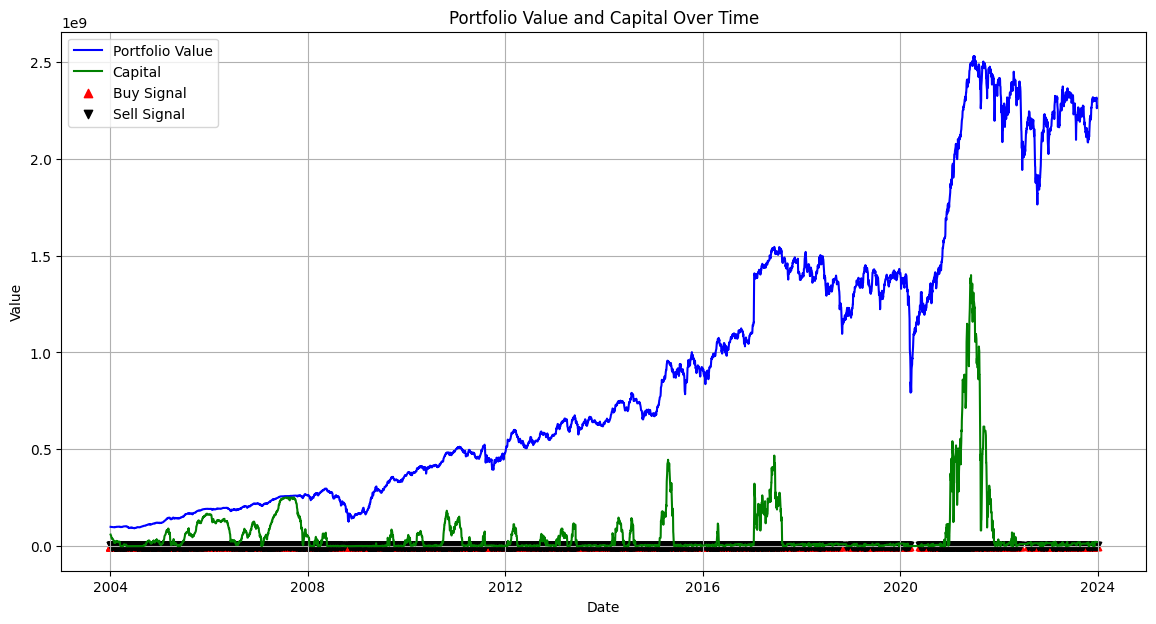

최종 포트폴리오 가치: 2267555783.0
CAGR: 0.1690264088978768
MDD: 57.15%
종목: 025820
종목: 007540
종목: 004490
종목: 011090
종목: 017370
종목: 002240
종목: 014440
종목: 004700
종목: 010660
종목: 001130
종목: 016590
종목: 006370
종목: 016090
종목: 015360
종목: 016880
종목: 023800
종목: 006120
종목: 005820
종목: 012610
종목: 014580
종목: 009460
종목: 003780
종목: 002200
종목: 010600
종목: 003090
종목: 003650
종목: 000970
종목: 004310
종목: 007690
종목: 004090
종목: 036580
종목: 009420
종목: 003220
종목: 004960
  매수가: 9150.0, 수량: 2432, 차수: 1
  매수가: 8760.0, 수량: 2627, 차수: 2
종목: 002810
종목: 017900
종목: 006040
종목: 015860
종목: 033780
종목: 002100
종목: 000590
종목: 003200
종목: 024090
  매수가: 13820.0, 수량: 1650, 차수: 1
  매수가: 12750.0, 수량: 1816, 차수: 2
  매수가: 12080.0, 수량: 1905, 차수: 3
  매수가: 11330.0, 수량: 2028, 차수: 4
종목: 001080
종목: 003850
종목: 009200
종목: 005800
종목: 001790
종목: 024070
종목: 017390
종목: 002460
종목: 000500
종목: 003550
종목: 012800
종목: 003720
종목: 000910
종목: 009680
종목: 013520
종목: 008250
종목: 006840
  매수가: 52400.0, 수량: 272, 차수: 1
  매수가: 47800.0, 수량: 274, 차수: 2
  매수가: 35650.0, 수량: 646, 

In [10]:
# 설정 파일 읽기
config = configparser.ConfigParser()
config.read('config.ini')

# 데이터베이스 연결 정보 설정
db_params = {
    'host': config['mysql']['host'],
    'user': config['mysql']['user'],
    'password': config['mysql']['password'],
    'database': config['mysql']['database'],
    'connection_timeout': 60 # 타임아웃을 60초로 증가
}
random.seed(61)
# 백테스팅 파라미터
initial_capital = 100000000  # 초기 자본 1억
num_splits=10
investment_ratio=0.1 #0.25
buy_threshold=30

start_date = '2004-01-01'
end_date = '2024-01-01'


# date = '2002-5-02'  # 조건을 만족하는 종목을 가져올 기준 날짜 2002-05-02부터 종목들이 등장
# pbr 조건은 2002년 4월 23일부터 생성됨 
# div 조건은 2000년 1월 4일부터 
# per 조건은 2000년 1월 4일부터 
# cf ) market_cap은 1995년
per_threshold = 10
pbr_threshold = 1.0
div_threshold = 1.0
min_additional_buy_drop_rate = 0.005
consider_delisting = False  # 상장폐지 고려 여부 설정
max_stocks = 40  # 최대 종목 수 설정


## 백테스팅 함수 실행 후 결과 분석
positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr = portfolio_backtesting(
    initial_capital, num_splits, investment_ratio, buy_threshold, start_date, end_date, db_params, per_threshold, pbr_threshold, div_threshold, min_additional_buy_drop_rate, consider_delisting, max_stocks
)

# MDD 계산
mdd = calculate_mdd(portfolio_values_over_time)
print(f"MDD: {mdd:.2%}")

# 결과 시각화
plot_backtesting_results(all_trading_dates, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals)
analyze_backtesting_results(positions_dict, total_portfolio_value, cagr, mdd)

### 병렬 백테스팅 실행 및 결과 저장

In [11]:

# 평균 CAGR과 평균 MDD를 함께 저장할 수 있는 DataFrame 열을 추가
columns = ["num_splits", "buy_threshold", "investment_ratio", "consider_delisting", "max_stocks", "Average_Total_Value", "Average_CAGR", "Average_MDD"]

num_splits_options = [10, 20, 30]
buy_threshold_options = [30, 40, 50]
investment_ratio_options = [0.05, 0.1, 0.2, 0.3]
consider_delisting_options = [False] # True # 상장폐지 고려 여부 옵션 추가 
max_stocks_options = [20, 30, 40]  # 최대 종목 수 옵션 추가

results_file = 'average_backtesting_results_resent.csv'
combinations = [(n, b, i, c, m) for n in num_splits_options for b in buy_threshold_options for i in investment_ratio_options for c in consider_delisting_options for m in max_stocks_options]

time_periods = [(2004, 2023), (2006, 2023), (2008, 2023), (2010, 2023), (2012, 2023), (2014, 2023)]

# 이미 계산된 조합을 건너뛰고 새로운 조합만 계산
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    futures = []
    for param in combinations:
        if not check_if_already_calculated(param[0], param[1], param[2], param[3], param[4], results_file):
            futures.append(executor.submit(average_cagr_wrapper, param))
    results = []
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        result = future.result()
        results.append(result)

# 결과 DataFrame 생성 및 저장
results_df = pd.DataFrame(results, columns=columns)
results_df.to_csv(results_file, index=False)

# 결과 출력
print(results_df.sort_values(by="Average_CAGR", ascending=False))

  0%|          | 0/108 [00:00<?, ?it/s]

2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
136
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
118
118
136
150
118
136
150
150
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
150
136
136
136
136
118
136
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
136
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-022004-01-02 진입종목수 0
2004-01-02 진입종목수 0
 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2004-01-02 진입종목수 0
2